# Задание №6 (работы 11-12)

## Подготовка данных

### Загрузка, масштабирование, понижение размерности

In [15]:
from typing import NamedTuple
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np

data = pd.read_csv('./data/ionosphere.data', header=None) # Load data

X = data[range(0, 34)]
y = data[34].map({"g": 1, "b": 0})
y.name = "class"

class ScaledData(NamedTuple):
    umap: object
    tsne: object

scaler = RobustScaler() # Выбран так как в предыдущей работе показал наилучшую эффективность.
umap_reducer = UMAP()
tsne_reducer = TSNE(init='random', learning_rate='auto')

scaler.fit(X)

X_scaled_reduced = [
    umap_reducer.fit_transform(scaler.transform(X)),
    tsne_reducer.fit_transform(scaler.transform(X)),
]

X = ScaledData(
    umap=pd.DataFrame(X_scaled_reduced[0], columns=['p1', 'p2']),
    tsne=pd.DataFrame(X_scaled_reduced[1], columns=['p1', 'p2'])
)

## Кластеризация

In [8]:
from sklearn.cluster import DBSCAN, KMeans
from fcmeans import FCM

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def scores(y_true, y_pred):
    return { 
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
    }

classifier = SVC(kernel="linear")
model = classifier.fit(X_train.umap, y_train.umap)

y_predicted = classifier.predict(X_test.umap)
print(scores(y_test, y_predicted))

{'accuracy': 0.7641509433962265, 'precision': 0.9180327868852459, 'f1': 0.8175182481751824, 'recall': 0.7368421052631579}


## Подбор гиперпараметров

In [9]:
from sklearn.model_selection import GridSearchCV

class Result(NamedTuple):
    y_predicted: object
    classifier: object

class ClassifierWithParameters(NamedTuple):
    classifier: object
    parameters: dict

classifiers = [
    ClassifierWithParameters(
        SVC(), parameters={ 
            "kernel": ["linear", "rbf", "poly", "sigmoid"],
            "C": list(map(lambda x: x/10, range(1, 11, 1))) 
        }
    ),
    ClassifierWithParameters(
        KNeighborsClassifier(), parameters={ 
            "n_neighbors": list(range(1, 21)),
            "leaf_size": list(range(1, 31)),
            "metric": ["euclidean", "manhattan", "chebyshev" ] }
    ),
    ClassifierWithParameters(
        RandomForestClassifier(),parameters={ 
            "n_estimators": [70, 150],
            "max_features": ['auto', 'sqrt', 'log2'],
            "min_samples_split": list(range(2, 5)),
            "min_samples_leaf": list(range(1, 5)) }
    )
]

classifier, parameters = classifiers[0]

scaled_sets = [
    ("UMAP", X_train.umap, X_test.umap, y_train.umap), 
    ('T-SNE', X_train.tsne, X_test.tsne, y_train.tsne)]

results = {}

for label_, X_train_, X_test_, y_train_ in scaled_sets:
    for classifier_, parameters in classifiers:
        label = f"{type(classifier_).__name__}-{label_}"
        
        classifier = GridSearchCV(classifier_, param_grid=parameters)
        
        model = classifier.fit(X_train_.values, y_train_.values)
        
        classifier = model.best_estimator_
        y_predicted = classifier.predict(X_test_.values)
        results[label] = Result(y_predicted, classifier)
        print(label, model.best_params_)
        print(label, scores(y_test, y_predicted))

SVC-UMAP {'C': 0.6, 'kernel': 'rbf'}
SVC-UMAP {'accuracy': 0.8301886792452831, 'precision': 0.9142857142857143, 'f1': 0.8767123287671234, 'recall': 0.8421052631578947}
KNeighborsClassifier-UMAP {'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 3}
KNeighborsClassifier-UMAP {'accuracy': 0.8679245283018868, 'precision': 0.9305555555555556, 'f1': 0.9054054054054054, 'recall': 0.881578947368421}
RandomForestClassifier-UMAP {'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 70}
RandomForestClassifier-UMAP {'accuracy': 0.8490566037735849, 'precision': 0.8947368421052632, 'f1': 0.8947368421052632, 'recall': 0.8947368421052632}
SVC-T-SNE {'C': 1.0, 'kernel': 'rbf'}
SVC-T-SNE {'accuracy': 0.6792452830188679, 'precision': 0.75, 'f1': 0.7875, 'recall': 0.8289473684210527}
KNeighborsClassifier-T-SNE {'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 1}
KNeighborsClassifier-T-SNE {'accuracy': 0.6415094339622641, 'precision': 0.7567567567567568, 'f1': 0.7

## Визуализация

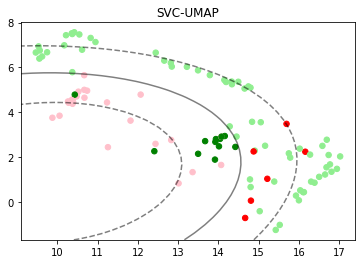

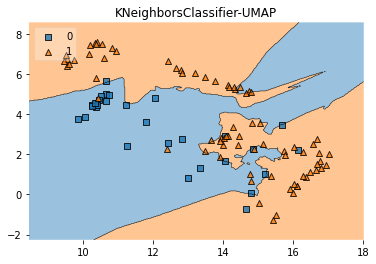

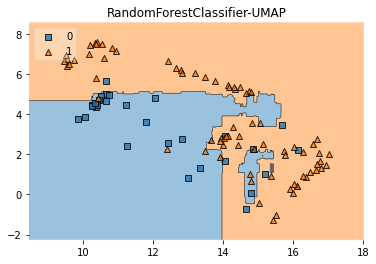

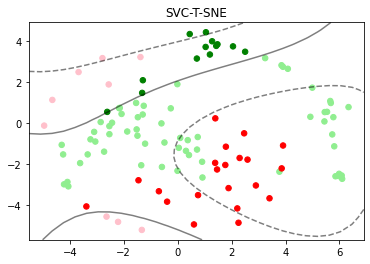

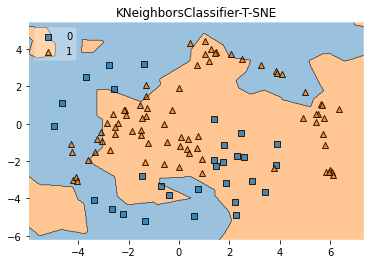

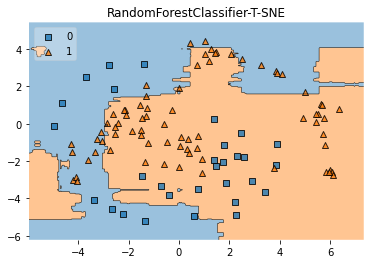

In [11]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

def plot_SVM(X, y_act, y_pred, clf, text):
    Y = pandas.concat([pandas.Series(y_act, name="class"), pandas.Series(y_pred, name="pred", index=y_act.index)], axis=1)
    color_map = {"11": "lightgreen", "00": "pink", "10": "green", "01": "red"}
    colors = Y.apply(lambda x: f"{x['class']}{x['pred']}", axis=1).map(color_map)
    
    plt.scatter(X["p1"], X["p2"], c=colors, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = numpy.linspace(xlim[0], xlim[1], 30)
    yy = numpy.linspace(ylim[0], ylim[1], 30)
    YY, XX = numpy.meshgrid(yy, xx)
    xy = numpy.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"])
    plt.title(text)
    plt.show()

def plot_DR(X, y_act, y_pred, clf, text):
    plot_decision_regions(X.to_numpy(), y_act.to_numpy(), clf=clf, legend=2)
    plt.title(text)
    plt.show()

plot_functions = [ plot_DR, plot_DR, plot_DR ]

for label_, _, X_test_, _ in scaled_sets:
    for (classifier_, parameters), plot in zip(classifiers, plot_functions):
        label = f"{type(classifier_).__name__}-{label_}"
        plot(X_test_, y_test, results[label].y_predicted, results[label].classifier, label)